In [1]:
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from pprint import pprint

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### Загрузка датасета:

In [3]:
train_data = {}

for class_path in glob('C:/Users/seraf/Downloads/1/train/*'):
    class_name = int(class_path.split('\\')[-1])
    train_data[class_name] = glob(class_path+'/*')

In [4]:
test_data = {}

for class_path in glob('C:/Users/seraf/Downloads/1/valid/*'):
    class_name = int(class_path.split('\\')[-1])
    test_data[class_name] = glob(class_path+'/*')

In [5]:
num_of_classes = len(train_data)
print('Количество классов для обучения: ', num_of_classes)

Количество классов для обучения:  102


In [6]:
num_of_class_elems_train = [0 for element in range(len(train_data))]
for x in train_data.keys():
    num_of_class_elems_train[x-1] = len(train_data[x])
    

In [7]:
num_of_class_elems_test = [0 for element in range(len(test_data))]
for x in test_data.keys():
    num_of_class_elems_test[x-1] = len(test_data[x])

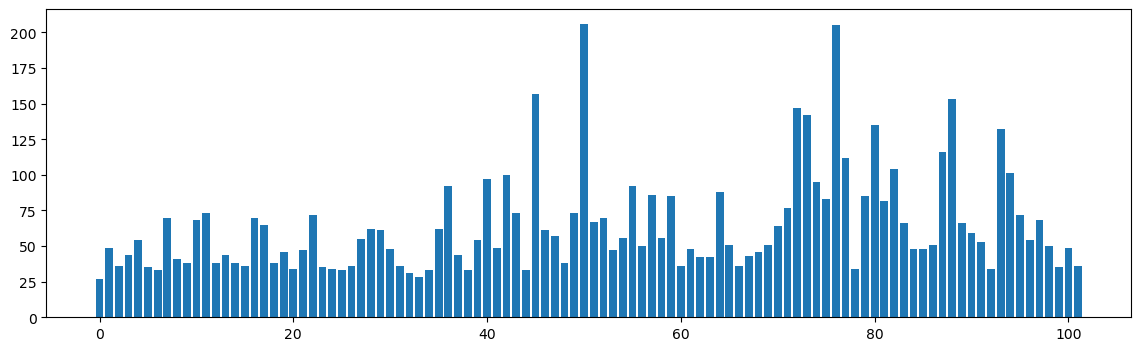

In [8]:
fig = plt.figure(figsize=(14,4))
plt.bar(range(num_of_classes), num_of_class_elems_train)
plt.show()

In [9]:
print('Максимальное количество изображений в классе: ', max(num_of_class_elems_train))
print('Минимальное количество изображений в классе: ', min(num_of_class_elems_train))
print('Суммарное количество изображений: ', sum(num_of_class_elems_train))


Максимальное количество изображений в классе:  206
Минимальное количество изображений в классе:  27
Суммарное количество изображений:  6565


In [10]:
median = np.median(num_of_class_elems_train)
print(median)

53.5


### Создание класса tf.data.Dataset

In [12]:
batch_size = 16
height = 224
width = 224

In [13]:
def make_train_dataset(x, i):
    
    train_dataset = (
        tf.data.Dataset.from_tensor_slices(x) # создаем экземпляр класса tf.data.Dataset
         .shuffle(buffer_size=len(x), reshuffle_each_iteration=True) # перемешиваем внутри класса много раз
         .map(lambda x: (x, i)) # добавляем метку класса каждому элементу внутри класса
        )
    
    
    return train_dataset

def make_test_dataset(x, i):
    
    test_dataset = (
        tf.data.Dataset.from_tensor_slices(x) # создаем экземпляр класса tf.data.Dataset
         .shuffle(buffer_size=len(x), reshuffle_each_iteration=True) # перемешиваем внутри класса 1 раз
         .map(lambda x: (x,i)) # добавляем метку класса каждому элементу внутри класса
        )
    
    return test_dataset


In [14]:
median = 40

In [15]:
train_datasets = []
test_datasets = []

for i, x in enumerate(train_data.values()):
    train_dataset = make_train_dataset(x, i)
    train_datasets.append(train_dataset.take(median))
    
    
for i, x in enumerate(test_data.values()):
    test_dataset = make_test_dataset(x, i)
    test_datasets.append(test_dataset)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### Балансировка датасета 

Сначала приведен неудачный способ сбалансировать датасета (через добавления вероятности весов для каждого класса, которые влияют на то, как часто будет выбираться элемент из определенного класса.

In [16]:
# from sklearn.utils import class_weight

# weights = list(class_weight.compute_class_weight(class_weight = 'balanced',
#                                                  classes = np.array(num_of_class_elems_train), 
#                                                  y = num_of_class_elems_train))

In [17]:
#s = sum(num_of_class_elems_train)
#keys = train_data.keys()
#train_datasets = tf.data.Dataset.sample_from_datasets(
#    train_datasets, weights=[1/len(train_data[x]) for x in keys])

#n = 0.52
#weights=[ 1/len(train_data[x]) for x in keys ]
#weights=[i*n for i in weights]
#a = print(sum(weights))


In [18]:
# train_datasets = tf.data.Dataset.sample_from_datasets(
#    train_datasets, weights, stop_on_empty_dataset=True)

In [19]:
# check_dataset = train_datasets
# check_num = [0 for element in range(len(train_data))]
# check = list(check_dataset.as_numpy_iterator())

# for i, x in enumerate(check):
#     x = list(x)
#     j = x[1]
#     check_num[j] = check_num[j] + 1
    


In [20]:
#fig = plt.figure(figsize=(14, 4))
#plt.bar(range(num_of_classes), check_num)
#plt.show()

Теперь работающий способ балансировки датасета:

In [21]:
num_of_classes=50

In [22]:
train_dataset = tf.data.Dataset.sample_from_datasets(train_datasets[0:num_of_classes])
test_dataset = tf.data.Dataset.sample_from_datasets(test_datasets[0:num_of_classes])

In [23]:
check_dataset = train_dataset
check_num = [0 for element in range(len(train_data))]
check = list(check_dataset.as_numpy_iterator())

for i, x in enumerate(check):
    x = list(x)
    j = x[1]
    check_num[j] = check_num[j] + 1
    

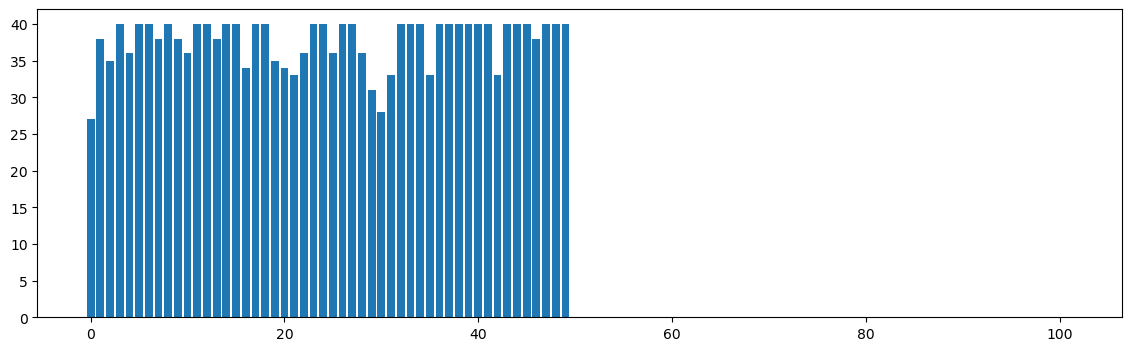

In [24]:
fig = plt.figure(figsize=(14, 4))
plt.bar(range(102), check_num)
plt.show()

### Подготовка данных (перемешивание, кодирование, создание пары (изображение, класс) )

In [25]:
len(list(train_dataset))

1886

In [26]:
train_dataset = train_dataset.shuffle(len(list(train_dataset)), reshuffle_each_iteration=True)

In [27]:
len(list(train_dataset))

1886

In [28]:
def prepare_pair(x, y):
    y = tf.one_hot(y, num_of_classes) # кодируем метку
    x = tf.io.read_file(x) # считываем файл
    x = tf.io.decode_jpeg(x, channels=3) # переводим jpeg в 3D массив высота*ширина*число_каналов
    x = tf.image.resize(x, [height, width]) # меняем размер изображение на заранее указанный
    
    x *= 1/255 # отмасштабируем все цветовые значения в диапазоне от 0 до 1
    
    return x, y

In [29]:
train_dataset = (
    train_dataset
    .map(lambda x,y: prepare_pair(x,y))
    .batch(batch_size, drop_remainder=True) # группируем датасет пачками размера batch_size
)

test_dataset = (
    test_dataset
    .map(lambda x,y: prepare_pair(x,y))
    .batch(batch_size, drop_remainder=True)
)

In [30]:
#for x, y in train_dataset.take(1):
#    plt.imshow(x[0])
#    plt.show()

#    print('Это', list(train_data.keys())[tf.argmax(y[0]).numpy()])
#    print('Номер класса', tf.argmax(y[0]).numpy())
#    print('Закодированная метка класса', y[0].numpy())

In [31]:
len(list(test_dataset))

21

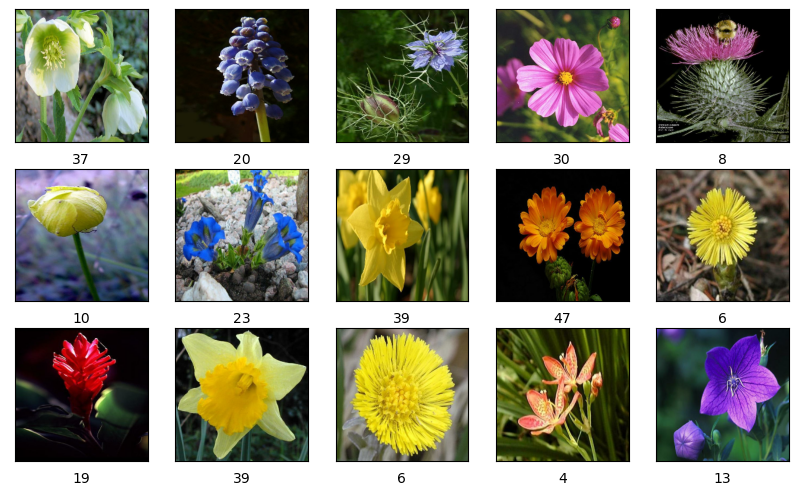

In [32]:
plt.figure(figsize=(10,10))
i = 0
for x,y in train_dataset.take(15):

    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i])
    plt.xlabel(tf.argmax(y[i]).numpy())
    i = i + 1

### Свёрточная нейросеть

# ![title](kQ0hXDaQv57sALXAJquxA.jpeg)

In [84]:
def plot_history(h):
  plt.plot(h.history['accuracy'])
  plt.plot(h.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(h.history['loss'])
  plt.plot(h.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [33]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(8, (3,3), strides = (1,1), padding='valid', activation = 'relu', input_shape = (height, width, 3)))
model.add(tf.keras.layers.MaxPool2D((2, 2)))

model.add(tf.keras.layers.Conv2D(16, (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D((2, 2)))


model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D((2, 2)))


model.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D((2, 2)))


model.add(tf.keras.layers.Flatten())


model.add(tf.keras.layers.Dense(128, activation='relu'))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(num_of_classes, activation='softmax'))

print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0

In [34]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optim = tf.keras.optimizers.Adam()
metrics = ["accuracy"]


model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [35]:
history = model.fit(train_dataset, validation_data = test_dataset, epochs = 10 )

Epoch 1/10
117/117 [==============================] - 21s 164ms/step - loss: 3.9141 - accuracy: 0.0208 - val_loss: 3.8324 - val_accuracy: 0.0327
Epoch 2/10
117/117 [==============================] - 20s 168ms/step - loss: 3.5417 - accuracy: 0.0700 - val_loss: 3.2715 - val_accuracy: 0.1190
Epoch 3/10
117/117 [==============================] - 19s 164ms/step - loss: 3.1068 - accuracy: 0.1362 - val_loss: 3.0394 - val_accuracy: 0.1577
Epoch 4/10
117/117 [==============================] - 20s 164ms/step - loss: 2.8570 - accuracy: 0.1827 - val_loss: 2.8454 - val_accuracy: 0.1905
Epoch 5/10
117/117 [==============================] - 20s 172ms/step - loss: 2.6242 - accuracy: 0.2463 - val_loss: 2.6738 - val_accuracy: 0.2500
Epoch 6/10
117/117 [==============================] - 19s 163ms/step - loss: 2.3125 - accuracy: 0.3248 - val_loss: 2.6701 - val_accuracy: 0.2411
Epoch 7/10
117/117 [==============================] - 19s 163ms/step - loss: 2.0865 - accuracy: 0.3921 - val_loss: 2.5258 - val_ac

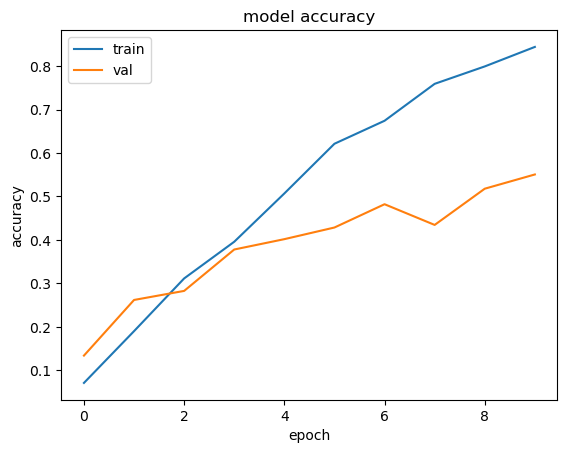

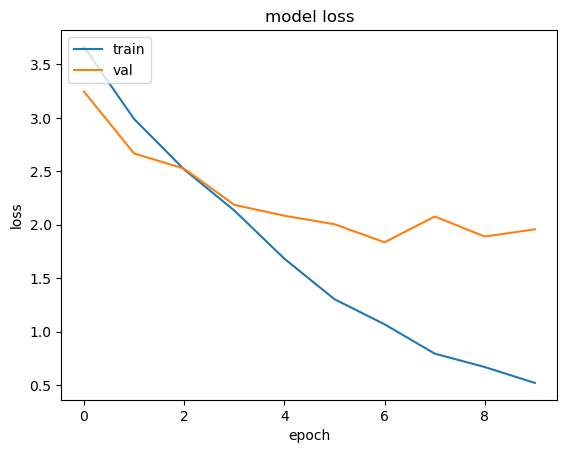

In [155]:
plot_history(history)

### Свёрточная нейросеть с остаточными связями

# ![title](photo_2022-12-06_19-48-37.jpg)


In [41]:
# Блок 1

input = tf.keras.layers.Input(shape=(height, width, 3))

b1 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding='same', 
                    activation='relu')(input)
b1 = tf.keras.layers.BatchNormalization()(b1) 
b1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1, 1), strides=(2, 2), padding='same',
                    activation='relu')(b1)
b1_out = tf.keras.layers.BatchNormalization()(b1)  

# Блок 2

b2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1, 1), strides=(1, 1), padding='same',
                           activation='relu')(b1_out)
b2 = tf.keras.layers.BatchNormalization()(b2)  
b2_add = tf.keras.layers.Add()([b1_out, b2])  
b2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same',
                          activation='relu')(b2_add)
b2_out = tf.keras.layers.BatchNormalization()(b2) 

# Блок 3

b3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same',
                    activation='relu')(b2_out)
b3 = tf.keras.layers.BatchNormalization()(b3) 
b3_add = tf.keras.layers.Add()([b2_out, b3])  
b3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same',
                    activation='relu')(b3_add)
b3_out = tf.keras.layers.BatchNormalization()(b3)

# Блок 4

b4_avg_p = tf.keras.layers.GlobalAveragePooling2D()(b2_out)
output = tf.keras.layers.Dense(num_of_classes, activation='softmax')(b4_avg_p)
model_res = tf.keras.Model(input, output)

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0

In [157]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optim = tf.keras.optimizers.Adam()
metrics = ["accuracy"]


model_res.compile(optimizer=optim, loss=loss, metrics=metrics)

In [158]:
history = model_res.fit(train_dataset, validation_data = test_dataset, epochs = 20 )

Epoch 1/20
117/117 [==============================] - 17s 126ms/step - loss: 3.4894 - accuracy: 0.1100 - val_loss: 3.9519 - val_accuracy: 0.0476
Epoch 2/20
117/117 [==============================] - 14s 115ms/step - loss: 3.0688 - accuracy: 0.1982 - val_loss: 3.8103 - val_accuracy: 0.0536
Epoch 3/20
117/117 [==============================] - 14s 115ms/step - loss: 2.8597 - accuracy: 0.2537 - val_loss: 3.3506 - val_accuracy: 0.1220
Epoch 4/20
117/117 [==============================] - 14s 117ms/step - loss: 2.7561 - accuracy: 0.2585 - val_loss: 2.9914 - val_accuracy: 0.1935
Epoch 5/20
117/117 [==============================] - 15s 122ms/step - loss: 2.6386 - accuracy: 0.2874 - val_loss: 2.6752 - val_accuracy: 0.2768
Epoch 6/20
117/117 [==============================] - 14s 118ms/step - loss: 2.5010 - accuracy: 0.3243 - val_loss: 3.3215 - val_accuracy: 0.2113
Epoch 7/20
117/117 [==============================] - 15s 124ms/step - loss: 2.4303 - accuracy: 0.3312 - val_loss: 2.9247 - val_ac

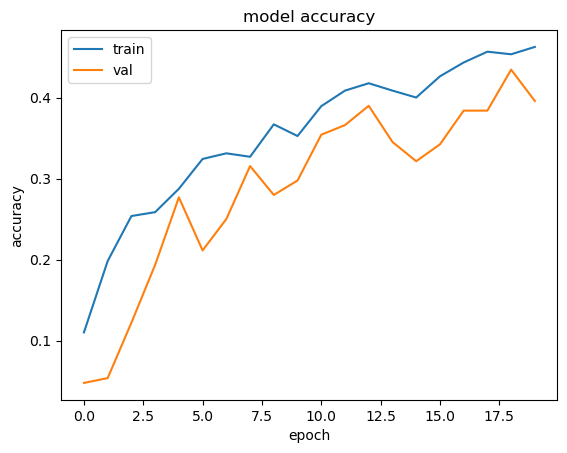

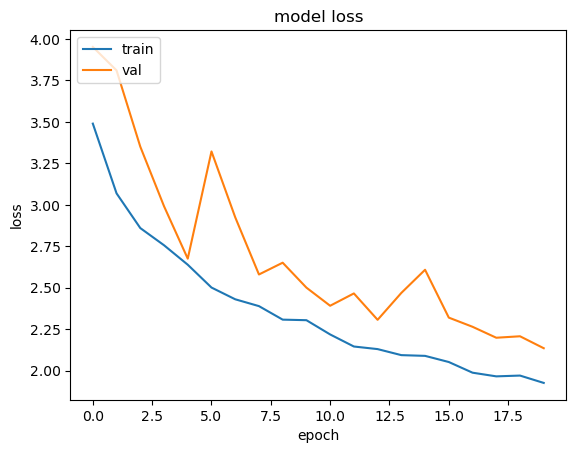

In [159]:
plot_history(history)

### Transfer Learning

In [46]:
vgg_model = tf.keras.applications.vgg16.VGG16()
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [47]:
transfer_model = keras.models.Sequential()
for layer in vgg_model.layers[0:-1]:
    transfer_model.add(layer)

In [48]:
for layer in transfer_model.layers:
    layer.trainable = False
    
transfer_model.add(tf.keras.layers.Dense(num_of_classes, activation='softmax'))

transfer_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [163]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optim = tf.keras.optimizers.Adam()
metrics = ["accuracy"]


transfer_model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [166]:
history = transfer_model.fit(train_dataset, validation_data = test_dataset, epochs = 10 )

Epoch 1/10
117/117 [==============================] - 191s 2s/step - loss: 2.9599 - accuracy: 0.2623 - val_loss: 2.4636 - val_accuracy: 0.3601
Epoch 2/10
117/117 [==============================] - 210s 2s/step - loss: 2.1126 - accuracy: 0.4380 - val_loss: 1.9353 - val_accuracy: 0.5000
Epoch 3/10
117/117 [==============================] - 203s 2s/step - loss: 1.7926 - accuracy: 0.5310 - val_loss: 1.9524 - val_accuracy: 0.5060
Epoch 4/10
117/117 [==============================] - 202s 2s/step - loss: 1.5325 - accuracy: 0.5876 - val_loss: 1.6199 - val_accuracy: 0.5536
Epoch 5/10
117/117 [==============================] - 202s 2s/step - loss: 1.3504 - accuracy: 0.6282 - val_loss: 1.8928 - val_accuracy: 0.5089
Epoch 6/10
117/117 [==============================] - 206s 2s/step - loss: 1.2307 - accuracy: 0.6608 - val_loss: 1.4658 - val_accuracy: 0.5893
Epoch 7/10
117/117 [==============================] - 206s 2s/step - loss: 1.1182 - accuracy: 0.6838 - val_loss: 1.3273 - val_accuracy: 0.6369

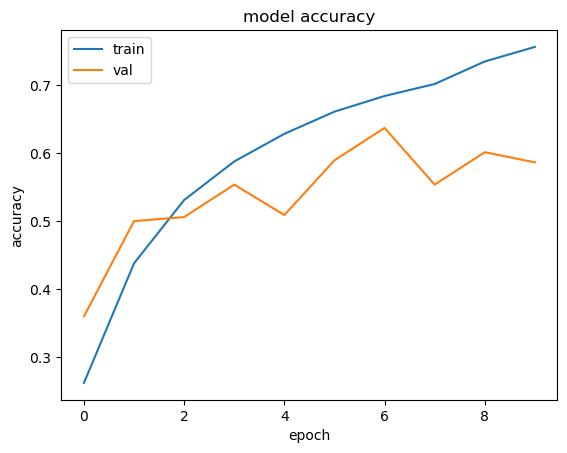

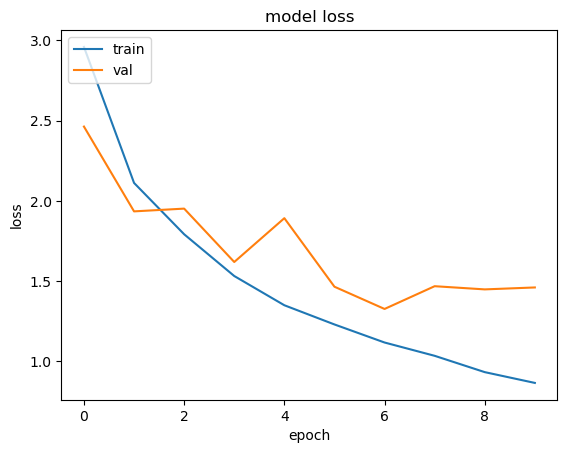

In [167]:
plot_history(history)

### Аугментация

In [33]:
import tensorflow_addons as tfa

def augment(x,y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    random_angle_radians = tf.random.uniform([batch_size], minval=-1.0, maxval=1.0)
    x = tfa.image.rotate(x, random_angle_radians, interpolation='bilinear')
    
    add_noise = tf.random.uniform([], minval=0, maxval=2)
    if add_noise == 0:
        #без шума
        x = x
    elif add_noise == 1:
        #слабый шум
        x = x + tf.random.normal(x.shape, mean=0.0, stddev=0.1)
    elif add_noise == 2:
        #сильный шум
        x = x + tf.random.normal(x.shape, mean=0.0, stddev=0.2)
    
    x = tf.clip_by_value(x, 0.0, 1.0) # после добавления шума, значения могут немного вылезти за пределы 0 и 1,
    # поэтому обрежем эти значения до ближайших
    return x,y

train_dataset = train_dataset.map(lambda x,y: augment(x,y))

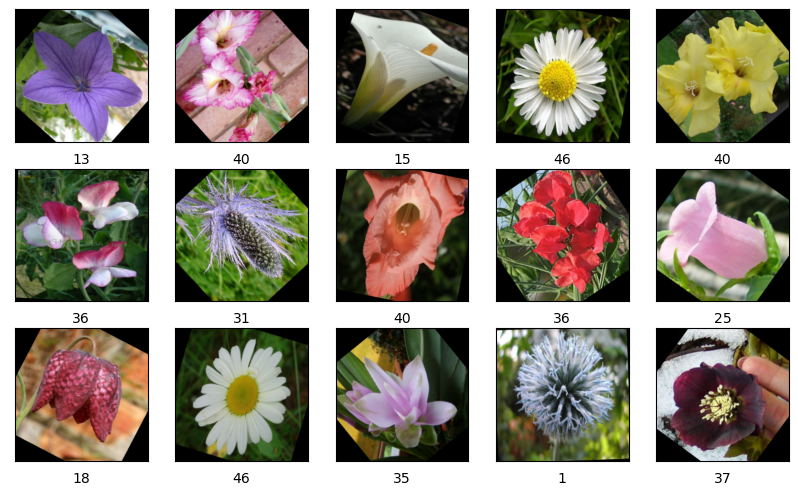

In [34]:
plt.figure(figsize=(10,10))
i = 0
for x,y in train_dataset.take(15):

    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i])
    plt.xlabel(tf.argmax(y[i]).numpy())
    i = i + 1


### Обучение на аугментированном датасете

### Свёрточная нейросеть

In [37]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optim = tf.keras.optimizers.Adam()
metrics = ["accuracy"]


model.compile(optimizer=optim, loss=loss, metrics=metrics)
history = model.fit(train_dataset, validation_data = test_dataset, epochs = 25 )

Epoch 1/25
117/117 [==============================] - 23s 174ms/step - loss: 3.7601 - accuracy: 0.0390 - val_loss: 3.4599 - val_accuracy: 0.0655
Epoch 2/25
117/117 [==============================] - 20s 169ms/step - loss: 3.2339 - accuracy: 0.1095 - val_loss: 2.9141 - val_accuracy: 0.1964
Epoch 3/25
117/117 [==============================] - 21s 180ms/step - loss: 2.8883 - accuracy: 0.1822 - val_loss: 2.7092 - val_accuracy: 0.2321
Epoch 4/25
117/117 [==============================] - 21s 173ms/step - loss: 2.6875 - accuracy: 0.2276 - val_loss: 2.5357 - val_accuracy: 0.2619
Epoch 5/25
117/117 [==============================] - 21s 175ms/step - loss: 2.5251 - accuracy: 0.2537 - val_loss: 2.4580 - val_accuracy: 0.2917
Epoch 6/25
117/117 [==============================] - 21s 181ms/step - loss: 2.3955 - accuracy: 0.2906 - val_loss: 2.2780 - val_accuracy: 0.3690
Epoch 7/25
117/117 [==============================] - 21s 173ms/step - loss: 2.2434 - accuracy: 0.3595 - val_loss: 2.3796 - val_ac

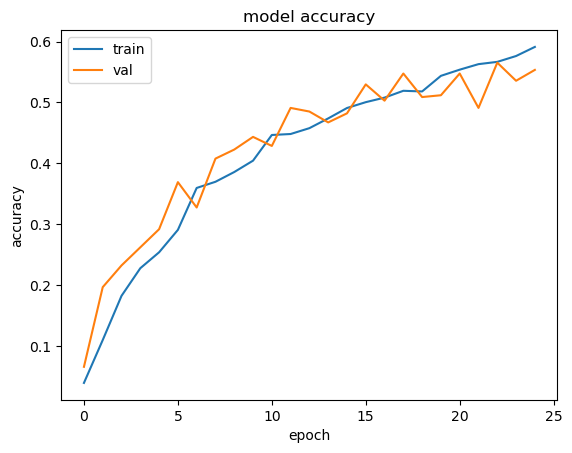

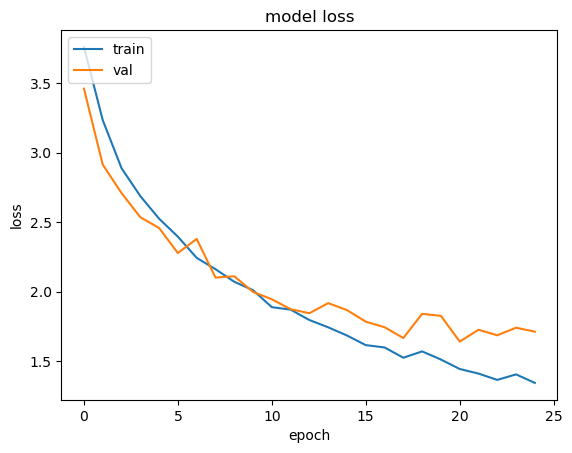

In [38]:
plot_history(history)

### Свёрточная нейросеть с остаточными связями

In [43]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optim = tf.keras.optimizers.Adam()
metrics = ["accuracy"]


model_res.compile(optimizer=optim, loss=loss, metrics=metrics)
history = model_res.fit(train_dataset, validation_data = test_dataset, epochs = 10 )

Epoch 1/10
117/117 [==============================] - 17s 128ms/step - loss: 3.4489 - accuracy: 0.1181 - val_loss: 3.8684 - val_accuracy: 0.0476
Epoch 2/10
117/117 [==============================] - 16s 134ms/step - loss: 3.0764 - accuracy: 0.1870 - val_loss: 3.8696 - val_accuracy: 0.0268
Epoch 3/10
117/117 [==============================] - 15s 128ms/step - loss: 2.8823 - accuracy: 0.2356 - val_loss: 3.4406 - val_accuracy: 0.0744
Epoch 4/10
117/117 [==============================] - 16s 131ms/step - loss: 2.7406 - accuracy: 0.2676 - val_loss: 2.9784 - val_accuracy: 0.1994
Epoch 5/10
117/117 [==============================] - 15s 128ms/step - loss: 2.6162 - accuracy: 0.2975 - val_loss: 2.7800 - val_accuracy: 0.2560
Epoch 6/10
117/117 [==============================] - 16s 135ms/step - loss: 2.5511 - accuracy: 0.3082 - val_loss: 2.6561 - val_accuracy: 0.2679
Epoch 7/10
117/117 [==============================] - 16s 130ms/step - loss: 2.4576 - accuracy: 0.3275 - val_loss: 2.5899 - val_ac

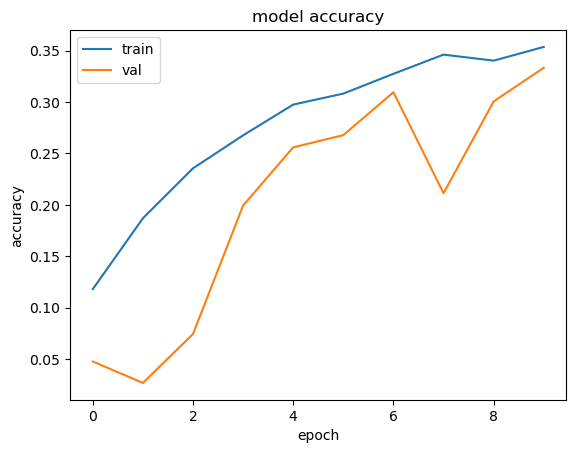

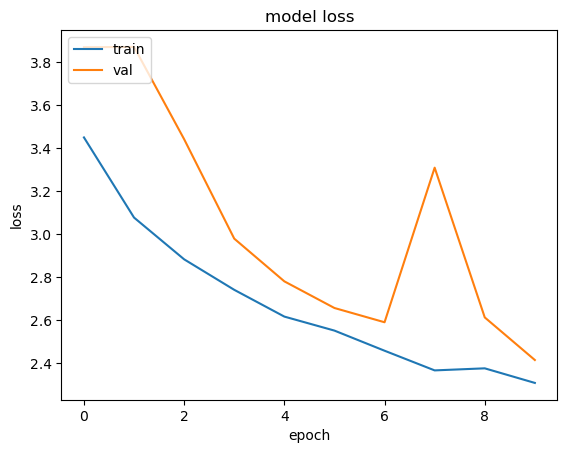

In [44]:
plot_history(history)

### Transfer Learning

In [50]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optim = tf.keras.optimizers.Adam()
metrics = ["accuracy"]


transfer_model.compile(optimizer=optim, loss=loss, metrics=metrics)
history = transfer_model.fit(train_dataset, validation_data = test_dataset, epochs = 7 )

Epoch 1/7
117/117 [==============================] - 174s 1s/step - loss: 4.1477 - accuracy: 0.1116 - val_loss: 3.1146 - val_accuracy: 0.2262
Epoch 2/7
117/117 [==============================] - 179s 2s/step - loss: 2.7816 - accuracy: 0.2938 - val_loss: 2.5256 - val_accuracy: 0.3869
Epoch 3/7
117/117 [==============================] - 182s 2s/step - loss: 2.3475 - accuracy: 0.3745 - val_loss: 2.0630 - val_accuracy: 0.4821
Epoch 4/7
117/117 [==============================] - 185s 2s/step - loss: 2.0631 - accuracy: 0.4380 - val_loss: 2.2642 - val_accuracy: 0.3780
Epoch 5/7
117/117 [==============================] - 182s 2s/step - loss: 1.8660 - accuracy: 0.5064 - val_loss: 1.9288 - val_accuracy: 0.5387
Epoch 6/7
117/117 [==============================] - 178s 2s/step - loss: 1.6545 - accuracy: 0.5449 - val_loss: 1.8267 - val_accuracy: 0.5208
Epoch 7/7
117/117 [==============================] - 189s 2s/step - loss: 1.6671 - accuracy: 0.5491 - val_loss: 1.6406 - val_accuracy: 0.5387


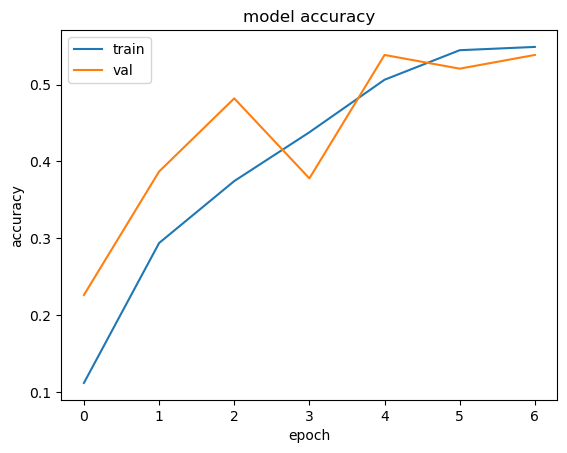

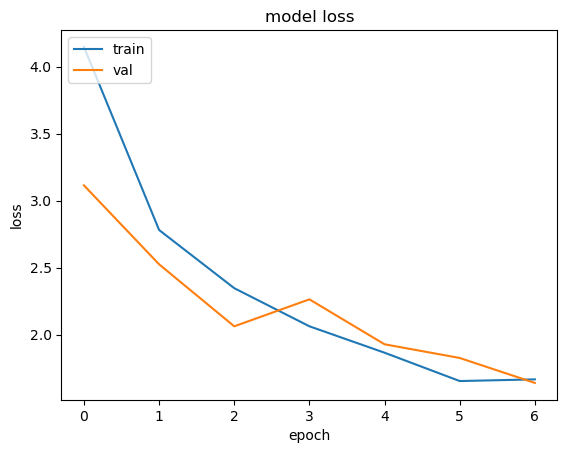

In [51]:
plot_history(history)

### Обман нейросети

In [86]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optim = tf.keras.optimizers.Adam()
metrics = ["accuracy"]


model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [93]:
history = model_res.fit(train_dataset, validation_data = test_dataset, epochs = 10 )

Epoch 1/10
117/117 [==============================] - 15s 121ms/step - loss: 1.7091 - accuracy: 0.5256 - val_loss: 2.1132 - val_accuracy: 0.4315
Epoch 2/10
117/117 [==============================] - 13s 110ms/step - loss: 1.6790 - accuracy: 0.5251 - val_loss: 2.1495 - val_accuracy: 0.4554
Epoch 3/10
117/117 [==============================] - 13s 107ms/step - loss: 1.6549 - accuracy: 0.5262 - val_loss: 2.0696 - val_accuracy: 0.4554
Epoch 4/10
117/117 [==============================] - 13s 109ms/step - loss: 1.6908 - accuracy: 0.5214 - val_loss: 2.1213 - val_accuracy: 0.4494
Epoch 5/10
117/117 [==============================] - 13s 111ms/step - loss: 1.6431 - accuracy: 0.5358 - val_loss: 1.9291 - val_accuracy: 0.5030
Epoch 6/10
117/117 [==============================] - 14s 118ms/step - loss: 1.5956 - accuracy: 0.5529 - val_loss: 2.0299 - val_accuracy: 0.4881
Epoch 7/10
117/117 [==============================] - 13s 107ms/step - loss: 1.6085 - accuracy: 0.5486 - val_loss: 2.0869 - val_ac

In [36]:
from tensorflow.keras.preprocessing import image
img = image.load_img('C:/Users/seraf/Downloads/1/image_070861.jpg', target_size=(224, 224))
input_image = image.img_to_array(img, 'channels_last')

input_image = (input_image / 255)
input_image = np.expand_dims(input_image, axis=0)
prediction = model.predict(input_image)

print(prediction)


1/1 [==============================] - 0s 203ms/step
[[1.56667716e-06 7.18052626e-01 2.13571326e-12 1.00639885e-12
  1.96445047e-13 8.86003537e-09 3.22393886e-14 2.73793321e-10
  2.52683276e-05 2.66216547e-15 4.30500857e-10 4.72453706e-07
  4.83405600e-08 5.45938797e-02 7.61162869e-11 8.94169072e-10
  1.55078349e-17 1.02414202e-03 4.66836827e-05 3.21013355e-10
  5.25350275e-04 1.25262467e-08 2.13284026e-11 6.76529948e-04
  2.15166211e-01 1.43569705e-05 5.44547765e-06 6.42882680e-09
  2.21115954e-07 2.72815325e-03 1.24301605e-05 3.55126359e-03
  3.55695448e-07 8.44144015e-05 1.02101985e-04 3.50874302e-10
  4.43826248e-05 2.38202361e-07 9.22524066e-08 2.34032086e-13
  6.46918409e-07 4.14897204e-06 3.28782597e-03 3.08095758e-12
  3.88603549e-16 5.89518781e-11 3.93158706e-09 1.24965752e-13
  1.53797461e-11 5.12189217e-05]]


In [37]:
max = 0
for i, x in enumerate(prediction[0]):
    if x>max:
        max = x
        k = i
print(k)
print(prediction[0][k])

1
0.7180526


In [1]:
from tensorflow.keras.preprocessing import image
from keras import backend as back
tf.compat.v1.disable_eager_execution()

target = 30
# скорость обучения
learning_rate = 0.4

model_input = model.layers[0].input
model_output = model.layers[-1].output

img = image.load_img('C:/Users/seraf/Downloads/1/image_070861.jpg', target_size=(224, 224))
original_image = image.img_to_array(img, 'channels_last')

original_image = original_image/255

original_image = np.expand_dims(original_image, axis=0)

cost_function = model_output[0, target]

# считаем градиент для нашего изображения

gradient = g.gradient(cost_function, model_input)

# создаем функцию, рассчитывающую градиент и ошибку
get_parameters = back.function([model_input, back.learning_phase()], [cost_function, gradient])

cost = 0.0
# улучшаем изображение
while cost < 0.8:
    # считаем параметры изменения
    cost, gradients = get_parameters([original_image, 0])

    original_image += gradients * learning_rate
    original_image = np.clip(original_image, -1.0, 1.0)

    print(cost)

# возвращаем картинку в нормальный вид
img = original_image[0] * 255

im = Image.fromarray(img.astype(np.uint8))
im.show()


NameError: name 'tf' is not defined